In [145]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming

%matplotlib inline

In [2]:
from nmt_run import *

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict


 29%|██▉       | 40526/138708 [00:00<00:00, 405255.56it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 391271.15it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1804
    1 |   256 |   1047
    2 |   512 |    559
    3 |   768 |    348
    4 |  1024 |    158
    5 |  1280 |     53
    6 |  1536 |      6
    7 |  1792 |      2
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1656
    1 |   256 |   1177
    2 |   512 |    546
    3 |   768 |    363
    4 |  1024 |    150
    5 |  1280 |     50
    6 |  1536 |     16
    7 | 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(log_dev_fil_name, delimiter=',', usecols = (0,1,2)).transpose()

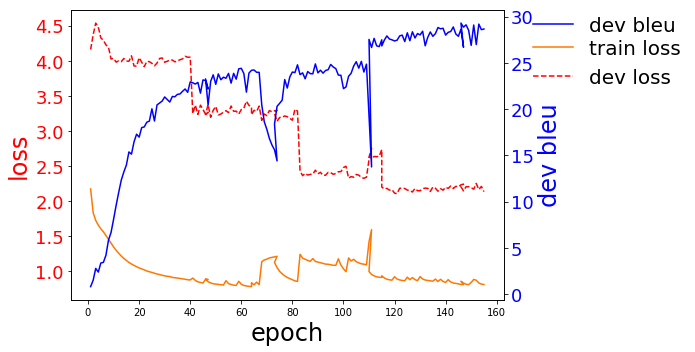

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [10]:
import nltk.translate.bleu_score

In [11]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [12]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, min_len=0, max_len=MAX_EN_LEN, play_audio=False):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(en.split(" ")) >= min_len and len(en.split(" ")) <= max_len:
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            display_pp = PrettyTable(["cat","sent"], hrules=True)
            display_pp.align = "l"
            display_pp.header = False
            display_pp.add_row(["es ref", textwrap.fill(es,50)])
            display_pp.add_row(["en ref", textwrap.fill(en,50)])
            display_pp.add_row(["en pred", textwrap.fill(p,50)])

            print(display_pp)
            if play_audio:
                play_utt(u, m_dict)
    

In [13]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key, min_len=0, max_len=2*MAX_EN_LEN):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(es.split(" ")) >= min_len and len(es.split(" ")) <= max_len:
            total_matching_len += 1
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))

    print("total utts matching length filters={0:d}".format(total_matching_len))

In [33]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, 
                              min_len=0, max_len=2*MAX_EN_LEN, stemmify=False):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
#     if stemmify:
#         stemmer = SnowballStemmer("english")
    
    for u in tqdm(utts, ncols=80):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            if type(m_dict[u][ref_key]) == list:
                if stemmify:
                    en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
                else:
                    en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
            else:
                en_r_list = []
                for r in m_dict[u][ref_key]:
                    if stemmify:
                        en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                    else:
                        en_r_list.append(" ".join([w.decode() for w in r]))
                en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            total_matching_len += 1
            if stemmify:
                t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
            else:
                t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
            t_str = t_str[:t_str.find('_EOS')]
            en_hyp.append(t_str)


    print("total utts matching length filters={0:d}".format(total_matching_len))
    
    with open("{0:s}_mt-output".format(key), "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open("{0:s}.ref0".format(key), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open("{0:s}_en.ref{1:d}".format(key,i), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [34]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 32

In [19]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [21]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True, mini=False)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 152


b=2,l=2.50,avg=2.33: 100%|██████████████████| 3977/3977 [11:49<00:00,  2.25it/s]

********** dev mean loss=2.3309
-
--------------------------------------------------------------------------------


In [22]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, 200
displayN = 50

In [23]:
display_words(m_dict, v_dict, fsh_pred_sents[:displayN], fsh_utts[:displayN], 
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

Utterance: 20051018_210220_279_fsp-A-19
+---------+----------------------------------------------------+
| es ref  | para poder que ellos te ayuden pero con la ayuda   |
|         | que te dan no es suficiente para que tu poder      |
|         | sobrevivas                                         |
+---------+----------------------------------------------------+
| en ref  | so that they are able to help you but the help     |
|         | that they give you is not enough for you to be     |
|         | able to survive                                    |
+---------+----------------------------------------------------+
| en pred | for the judge that they help you but they help you |
|         | help you that you survive                          |
+---------+----------------------------------------------------+
Utterance: 20051018_210220_279_fsp-A-67
+---------+----------------------------------------------------+
| es ref  | fueron por lo que tenían ir y pedir ayuda y tal    |
|         

In [24]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/chainer2/speech2text")

In [25]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              fsh_pred_sents, 
                              fsh_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

# chrf = [0]*4

# for ref_i in range(4):
#     _, chrf[ref_i], _, _ = calc_bleu(m_dict, 
#                               v_dict, 
#                               fsh_pred_sents[:n], 
#                               fsh_utts[:n], 
#                               dec_key, 
#                               min_len=min_len, 
#                               max_len=max_len, 
#                               ref_index=ref_i)
#     # end for

# # print chrf score
# for i in range(4):
#     print("CHRF score on: {0:s} = {1:.2f}, using reference = {2:d}".format(key, chrf[i] * 100, i))

# print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 38480.92it/s]

min length=0, max length=200
total utts matching length filters=3977


BLEU score on: fisher_dev = 28.96
------------------------------------------------------------


In [26]:
# list(zip(h,r[:5]))

In [27]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [28]:
# print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
# for weights in all_weights:
#     b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
#     print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [29]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.44 |    37.28|    22.13 |    13.31
recall     |    62.38 |    36.04|    21.37 |    12.83


In [30]:
pred_path = "/afs/inf.ed.ac.uk/group/project/lowres/work/installs/fisher-callhome-corpus/corpus/ldc"
pred_fname = os.path.join(pred_path, "fisher_dev.pred")

In [35]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_pred_sents, fsh_utts, 
                                           dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 41073.24it/s]

min length=0, max length=200
total utts matching length filters=3977


done


In [36]:
stem('tion')

'tion'

In [37]:
len(en_ref),len(en_hyp)

(3977, 3977)

### Callhome dev

In [ ]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 32

In [ ]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
call_pred_sents, call_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
display_words(m_dict, v_dict, call_pred_sents[:displayN], call_utts[:displayN],
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

In [ ]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              call_pred_sents, 
                              call_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [133]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

  bleu score (0-100) | uni-bi-tri-quad     
               64.33 | 1.00-0.00-0.00-0.00 
               37.22 | 0.00-1.00-0.00-0.00 
               22.10 | 0.00-0.00-1.00-0.00 
               13.29 | 0.00-0.00-0.00-1.00 
               48.93 | 0.50-0.50-0.00-0.00 
               37.54 | 0.33-0.33-0.33-0.00 
               28.96 | 0.25-0.25-0.25-0.25 


In [134]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.44 |    37.28|    22.13 |    13.31
recall     |    62.38 |    36.04|    21.37 |    12.83


In [ ]:
call_en_ref, call_en_hyp = write_predictions_to_file(m_dict, v_dict, call_pred_sents, call_utts, 
                                                     dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

In [ ]:
len(call_en_ref),len(call_en_hyp)

### Google metrics

In [146]:
google_s2t_path_hyps = "./google-s2t/e2e_ast_decode/hyps/fisher_dev/"
google_s2t_path_refs = "./google-s2t/e2e_ast_decode/refs/fisher_dev/"

In [165]:
ref_lines = []
for fname in os.listdir(google_s2t_path_refs):
    with open(os.path.join(google_s2t_path_refs,fname), "r") as in_f:
        ref_lines.append([line.rstrip('\n').split() for line in in_f])

In [166]:
with open(os.path.join(google_s2t_path_hyps,'fisher_spa_eng_ast_003_base_r0.txt'), "r") as in_f:
    hyps = list(line.rstrip('\n').split() for line in in_f)

In [167]:
refs = []
for i in range(len(ref_lines[0])):
    refs.append([ref_lines[0][i], ref_lines[1][i], ref_lines[2][i], ref_lines[3][i]])

In [169]:
corpus_bleu(refs, hyps)

0.4520259607446546

In [176]:
for i in range(len(refs[0])):
    print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([ref[i] for ref in refs], hyps)))

chrf score using ref:1 = 0.667
chrf score using ref:2 = 0.637
chrf score using ref:3 = 0.622
chrf score using ref:4 = 0.592


In [181]:
for i in range(len(refs[0])):
    print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([ref[i] for ref in r], h)))

chrf score using ref:1 = 0.471
chrf score using ref:2 = 0.559
chrf score using ref:3 = 0.521
chrf score using ref:4 = 0.374


In [178]:
_, _ = corpus_precision_recall(refs, hyps)

min length=0, max length=240
total utts=3979
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    76.60 |    53.98|    38.00 |    26.57
recall     |    76.08 |    53.60|    37.72 |    26.37


In [179]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.44 |    37.28|    22.13 |    13.31
recall     |    62.38 |    36.04|    21.37 |    12.83


### Prep Google data

In [339]:
kaldi_segment_map_path = os.path.join(out_path,'kaldi_segment_map.dict')
rev_map_dict_path = os.path.join(out_path,'rev_map.dict')
kaldi_segment_map = pickle.load(open(kaldi_segment_map_path, "rb"))
rev_map_dict = pickle.load(open(rev_map_dict_path, "rb"))


google_s2t_path_mapping = "./google-s2t/e2e_ast_decode/mapping/fisher_dev/"
google_s2t_ref0 = os.path.join(google_s2t_path_mapping, "sorted-normalized-fisher_dev.en.0.mapping")

google_s2t_map_path = os.path.join(out_path, "google_s2t_map.dict")
google_s2t_rev_map_path = os.path.join(out_path, "google_s2t_rev_map.dict")
google_s2t_refs_path = os.path.join(out_path, "google_s2t_refs.dict")
google_s2t_hyps_path = os.path.join(out_path, "google_s2t_hyps.dict")

In [340]:
def prep_google_data():

    google_s2t_map = {}
    google_s2t_rev_map = {}

    r_m_dict = rev_map_dict['fisher_dev']
    with open(google_s2t_ref0, "r") as in_f:
        for i, line in enumerate(in_f, start=1):
            wav_f = line.split(".wav")[0].replace("fisher_dev/", "")
            key_1 = wav_f[:wav_f.find("_fsp")+len("_fsp")]
            key_2 = wav_f.rsplit("_fsp",1)[1].split("_")[0]
            google_s2t_map[i] = r_m_dict[key_1+key_2]
            google_s2t_rev_map[r_m_dict[key_1+key_2]] = i
        # end for
    # end with
    pickle.dump(google_s2t_map, open(google_s2t_map_path, "wb"))
    pickle.dump(google_s2t_rev_map, open(google_s2t_rev_map_path, "wb"))
    
    google_s2t_refs = {}
    for fname in os.listdir(google_s2t_path_refs):
        with open(os.path.join(google_s2t_path_refs,fname), "r") as in_f:
            f_key = fname.rsplit("-",1)[-1].replace(".en.","_")
            google_s2t_refs[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_refs[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_refs, open(google_s2t_refs_path, "wb"))
    
    google_s2t_hyps = {}
    for fname in os.listdir(google_s2t_path_hyps):
        with open(os.path.join(google_s2t_path_hyps,fname), "r") as in_f:
            f_key = "fisher_dev_{0:s}".format(fname.rsplit("_")[-1].replace(".txt", ""))
            google_s2t_hyps[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_hyps[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_hyps, open(google_s2t_hyps_path, "wb"))

In [341]:
prep_google_data()

In [333]:
" ".join(map(lambda t: t.decode(), m_dict[rev_map_dict['fisher_dev']['20051009_182032_217_fsp.108']]['en_w'][0]))

'and my dad always taught us that that for you to be to believe in god you don t have to be involved with a church'

In [338]:
print(" ".join([w for w in google_s2t_refs['fisher_dev_0'][fsh_utts[0]]]))
print(" ".join([w for w in google_s2t_hyps['fisher_dev_r0'][fsh_utts[0]]]))
print(" ".join([w for w in h[0]]))

so that they are able to help you but the help that they give you is not enough for you to be able to survive
sure the way they help you but like help that they give you they don't need you can survive
for the judge that they help you but they help you help you that you survive


In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)